In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

In [3]:
e1_data = pd.read_csv("/home/amanmehta/workspace/ucla/ensemble_qc_lab_qnt411/lab_data/exp1_fourier.csv", header=None)

In [4]:
e1_data

,0,1,2
0,-35.3470,-0.048125,-0.077531
1,-35.3446,-0.095718,-0.055806
2,-35.3422,0.140033,-0.065687
3,-35.3397,0.062902,-0.168841
4,-35.3373,-0.051466,0.087849
...,...,...,...
32763,44.8028,-0.019017,-0.002080
32764,44.8053,-0.085729,-0.094765
32765,44.8077,-0.074298,-0.075279
32766,44.8101,0.056571,-0.105091


Text(0.5, 1.0, 'Water T1')

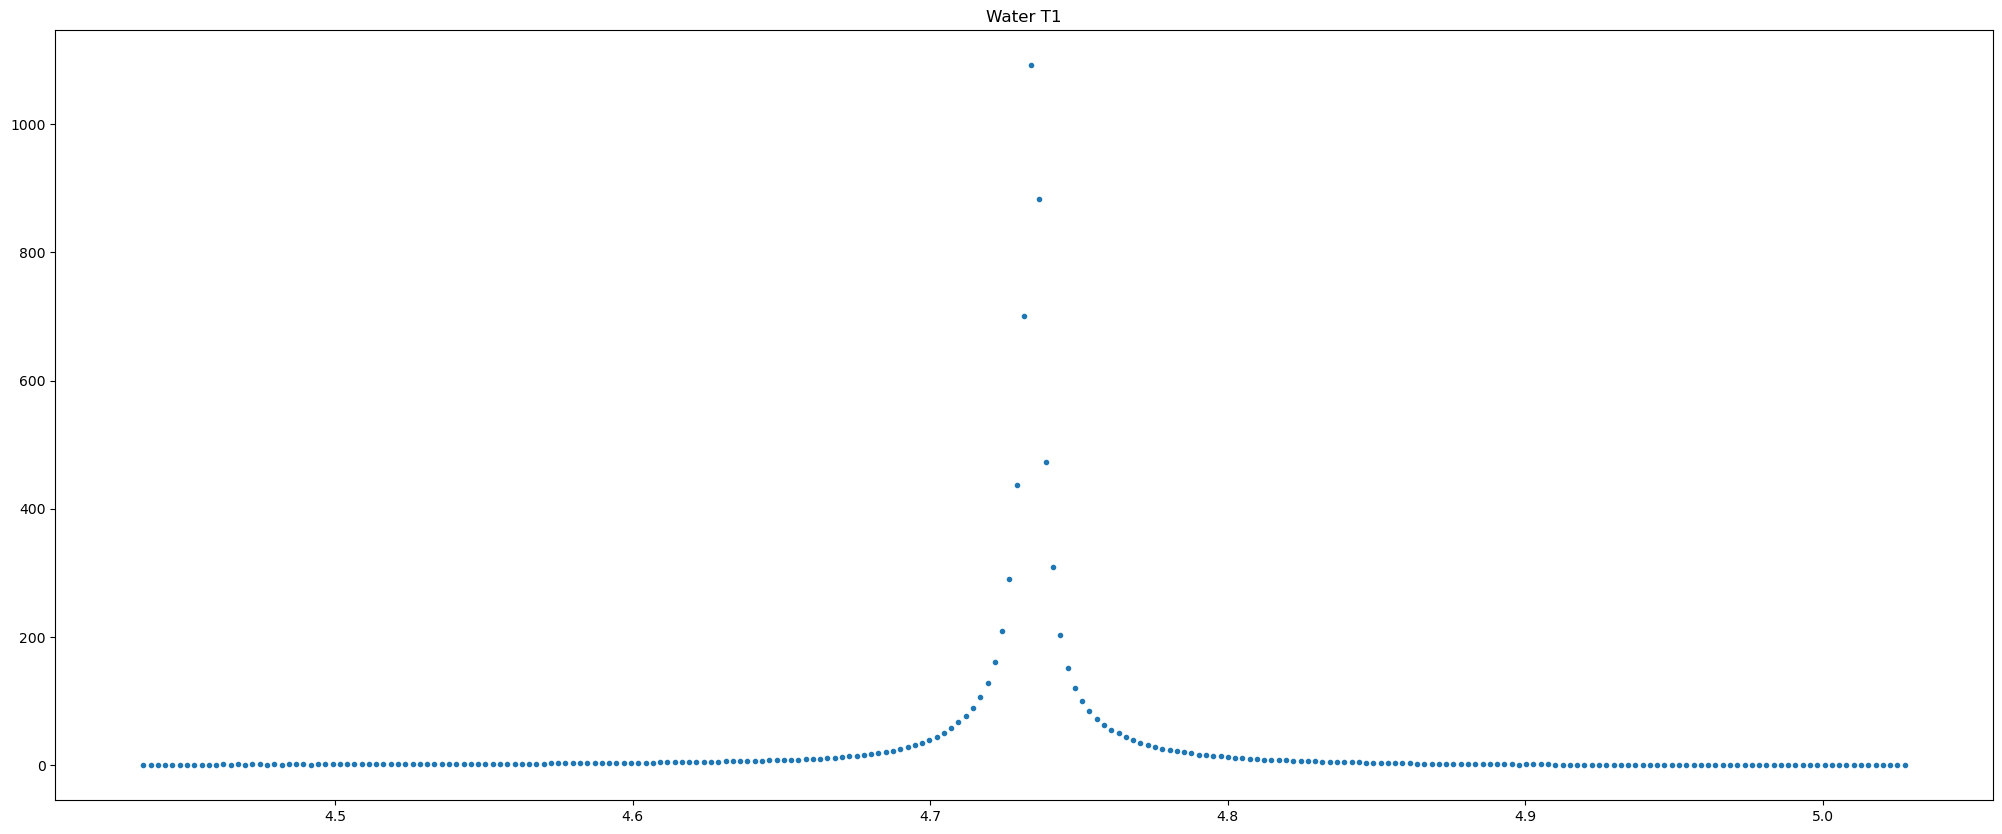

In [5]:
xs = np.array(e1_data.iloc[:,0]) 
ys = np.array(e1_data.iloc[:,1])

frac = 2.015

xsp = xs[int(len(xs)/frac):len(xs) - int(len(xs)/frac) -1]
ysp = ys[int(len(ys)/frac):len(ys) - int(len(ys)/frac) -1]

fig,ax = plt.subplots(1, figsize=(25,10))

ax.plot(xsp, ysp, '.')
ax.set_title("Water T1")

In [6]:
# define the fitting function
def lorentzian(x, m, a, Omega, c):
    return m*(a/((x-Omega)**2 + a*a)) + c

[4.76425787e+00 4.53160065e-03 4.73438265e+00 5.27719756e+00]
441.3451572386105


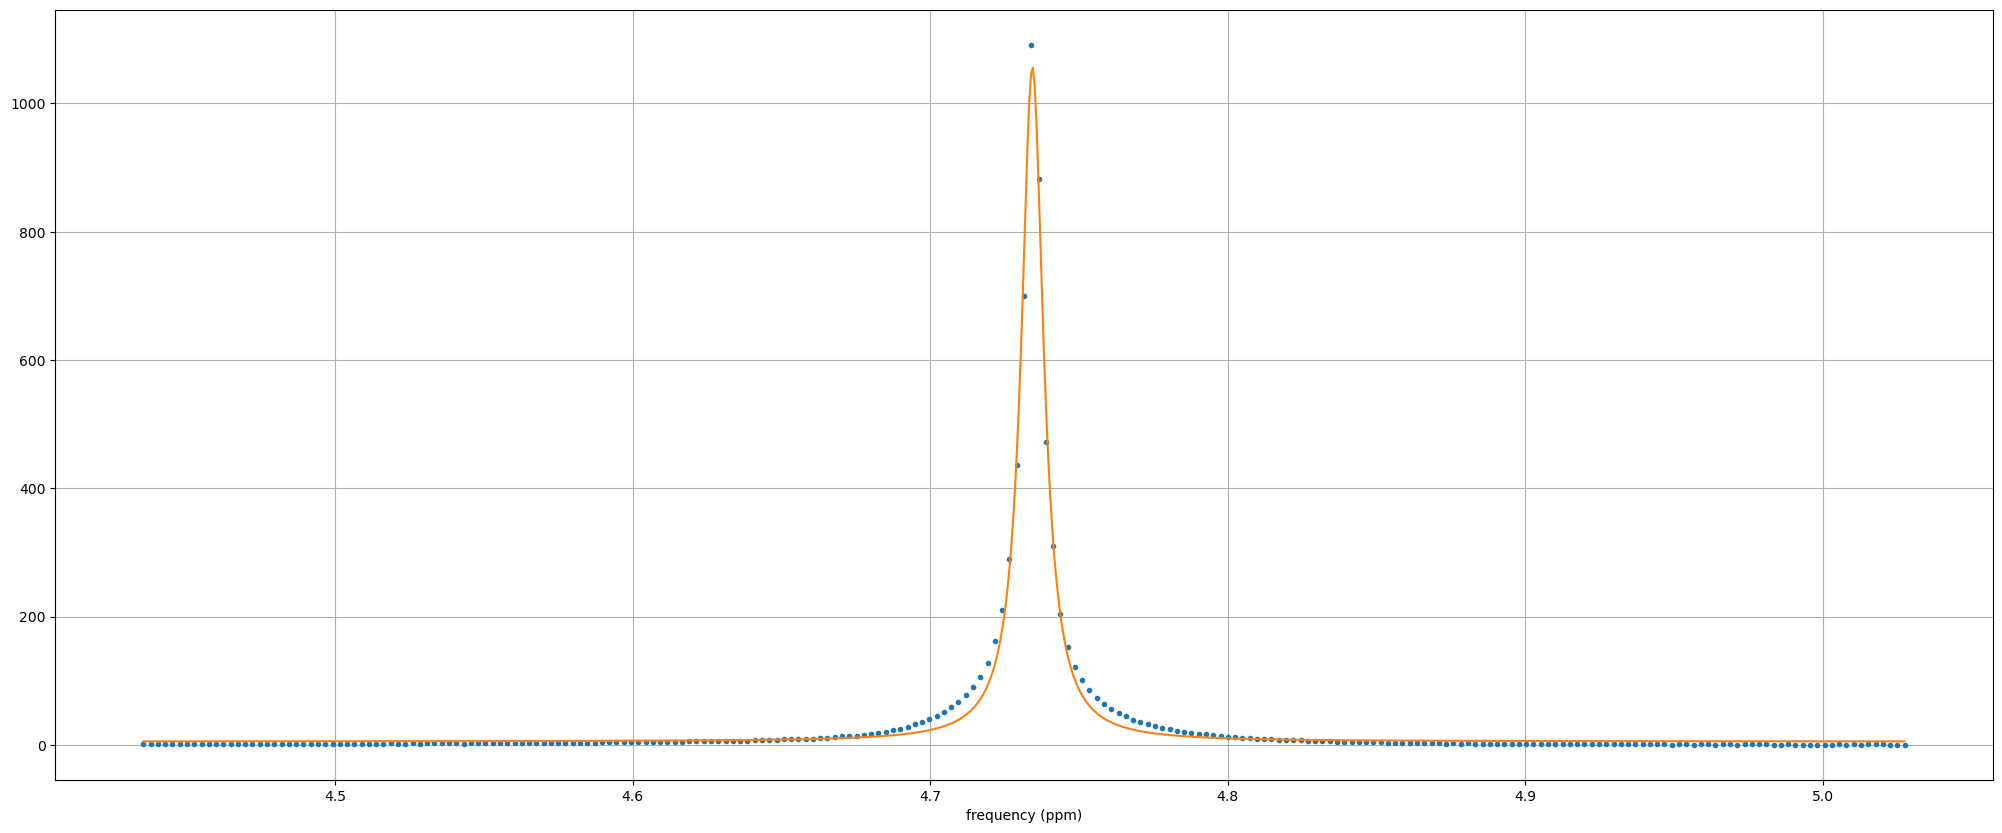

In [7]:
# perform the fit
# Your code goes here, the results should be similar to the following plot

initial_guess = [10,0.01,4.75,0]

popt, pcov = scipy.optimize.curve_fit(lorentzian, xsp, ysp, initial_guess)
print(popt)

x_val = np.arange(min(xsp), max(xsp), (max(xsp)- min(xsp))/1000)

fig,ax = plt.subplots(1, figsize=(25,10))
ax.plot(xsp, ysp, '.')
ax.plot(x_val, lorentzian(x_val, *popt))
ax.set_xlabel("frequency (ppm)")
ax.grid()
print(2/popt[1])

In [8]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    

    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]


    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

In [9]:
e1_fid_data = pd.read_csv("/home/amanmehta/workspace/ucla/ensemble_qc_lab_qnt411/lab_data/exp1_fid.csv", header=None)

e1_fid_data



,0,1,2
0,0.0,2269.51000,0.00000
1,0.2,2280.85000,-15.21030
2,0.4,2279.10000,-21.57760
3,0.6,2272.42000,-10.01470
4,0.8,2268.77000,-10.70740
...,...,...,...
32763,6552.6,7.01860,-2.95623
32764,6552.8,3.05615,-8.98109
32765,6553.0,3.96870,5.02488
32766,6553.2,1.95625,7.01235


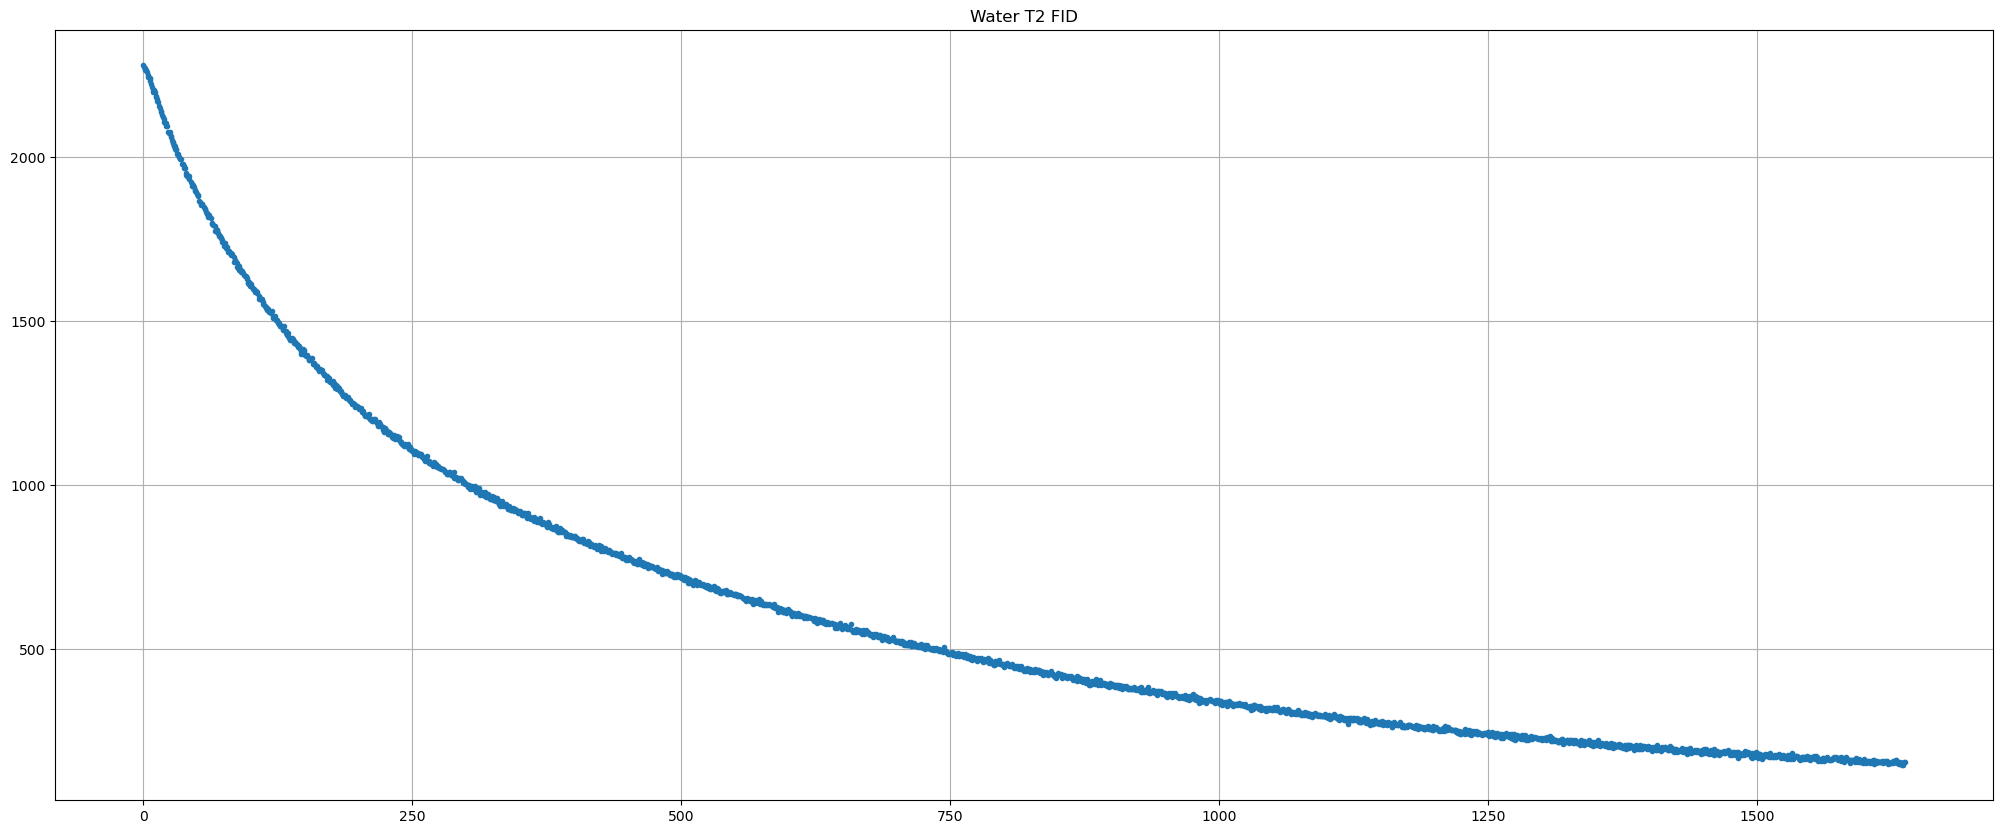

In [10]:
xs = np.array(e1_fid_data.iloc[:,0]) 
ys = np.array(e1_fid_data.iloc[:,1])

xs = xs[0:int(len(xs)/2)]
ys = ys[0:int(len(xs)/2)]

lmin, lmax = hl_envelopes_idx(ys)

fig,ax = plt.subplots(1, figsize=(25,10))

ax.plot(xs[lmax], ys[lmax], '.')
ax.set_title("Water T2 FID")
ax.grid()

In [11]:
# define the fitting function
def decay_exp(x, T2, m, delta, x0, c):
    return m*(np.cos(delta*(x-x0))*np.exp(-1*(x-x0)/T2)) + c

def closest_value(input_list_x, input_list_y, input_value):
 
  arr = np.asarray(input_list_y)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return input_list_x[i], i

[ 3.89962596e+02  8.83232181e+02 -3.16948233e-08  2.99272527e+02
  1.70405246e+02]
0.002264410246122443
intersection value: (398.8, 1994)


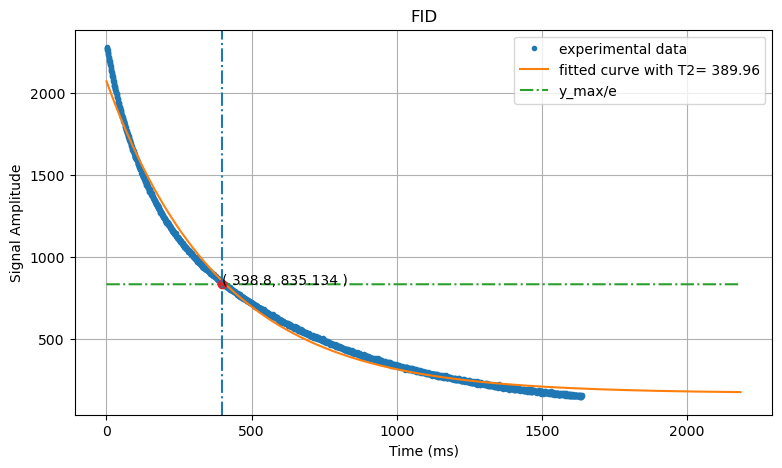

In [16]:
initial_guess = [350,2250,0.004,0,0]

popt, pcov = scipy.optimize.curve_fit(decay_exp, xs[lmax], ys[lmax], initial_guess)
print(popt)

x_val = np.arange(min(xs)/1.5, max(xs)/1.5, (max(xs)- min(xs))/10000)

intersection_point = closest_value(xs, ys, ys[0]/np.e)[1]

fig,ax = plt.subplots(1, figsize=(9,5))
ax.plot(xs[lmax], ys[lmax], '.', label="experimental data")
ax.plot(x_val, decay_exp(x_val, *popt), label="fitted curve with T2= " + str(np.round(popt[0],2)))
ax.plot(x_val, [ys[intersection_point]]*len(x_val), label="y_max/e", linestyle= '-.')
ax.plot(xs[intersection_point], ys[intersection_point], 'o' )
ax.axvline(x = xs[intersection_point], linestyle="-.")
ax.annotate("( "+ str(xs[intersection_point]) + ", " + str(ys[intersection_point]) + " )", (xs[intersection_point], ys[intersection_point]))

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Signal Amplitude")
ax.set_title("FID")
ax.grid()
print(2/popt[1])
ax.legend()

print("intersection value: " +str(closest_value(xs, ys, ys[0]/np.e)))

In [18]:
print(pcov)

[[ 2.96557517e+00 -1.84941365e+06  3.21547807e-03  8.16549984e+05
  -2.77446632e+00]
 [-1.84941671e+06  4.15062011e+15  1.11327974e+05 -1.83257048e+15
   8.53094272e+06]
 [ 3.21547798e-03  1.11328055e+05  2.49892073e-03 -4.91532552e+04
  -1.57764487e-02]
 [ 8.16551335e+05 -1.83257048e+15 -4.91531582e+04  8.09111529e+14
  -3.76656091e+06]
 [-2.77446633e+00  8.53093973e+06 -1.57764488e-02 -3.76655958e+06
   3.95703081e+00]]


In [30]:
e5_fid_data = pd.read_csv("/home/amanmehta/workspace/ucla/ensemble_qc_lab_qnt411/lab_data/exp5p2_fid.csv", header=None)

e5_fid_data


,0,1,2
0,0.0,1898.330000,0.00000
1,0.2,1273.380000,1707.53000
2,0.4,-546.110000,2122.94000
3,0.6,-1989.180000,933.36300
4,0.8,-1950.440000,-856.79600
...,...,...,...
32763,6552.6,3.935020,4.82862
32764,6552.8,-1.685180,3.18750
32765,6553.0,-0.886545,1.89051
32766,6553.2,2.359560,3.18001


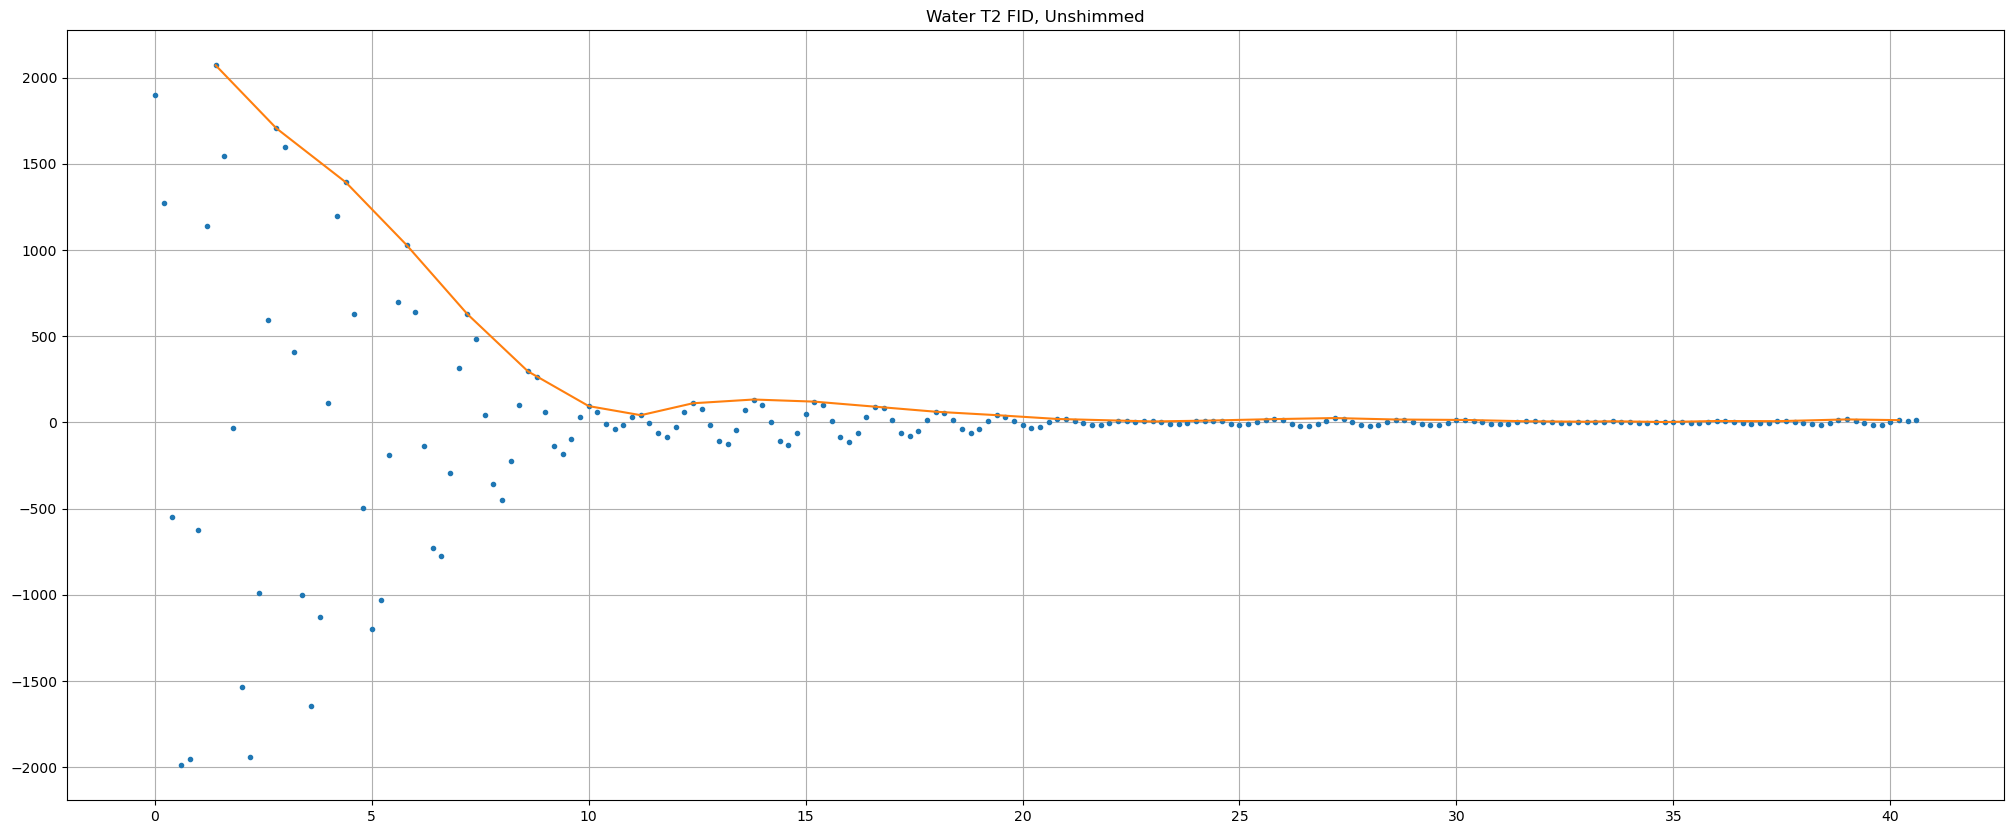

In [59]:
xs = np.array(e5_fid_data.iloc[:,0]) 
ys = np.array(e5_fid_data.iloc[:,1])

xs = xs[0:int(len(xs)/160)]
ys = ys[0:int(len(ys)/160)]

lmin, lmax = hl_envelopes_idx(ys)

fig,ax = plt.subplots(1, figsize=(25,10))

ax.plot(xs, ys, '.')
ax.plot(xs[lmax], ys[lmax], '-')
ax.set_title("Water T2 FID, Unshimmed")
ax.grid()

In [43]:
# define the fitting function
def decay_exp(x, T2, m, x0, c):
    return m*(np.exp(-1*(x-x0)/T2)) + c

def closest_value(input_list_x, input_list_y, input_value):
 
  arr = np.asarray(input_list_y)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return input_list_x[i], i

[ 4.54626040e+00  2.02617930e+03  1.86081259e+00 -1.13057437e+01]
[[ 1.70302879e-01  9.22177990e+08 -2.06914624e+06 -5.44794515e+00]
 [ 9.22177986e+08  1.34439587e+19 -3.01650188e+16 -1.64780808e+10]
 [-2.06914622e+06 -3.01650188e+16  6.76830672e+13  3.69728600e+07]
 [-5.44794518e+00 -1.64780812e+10  3.69728610e+07  6.18183619e+02]]
0.0009870794765012637
intersection value: (5.6, 28)


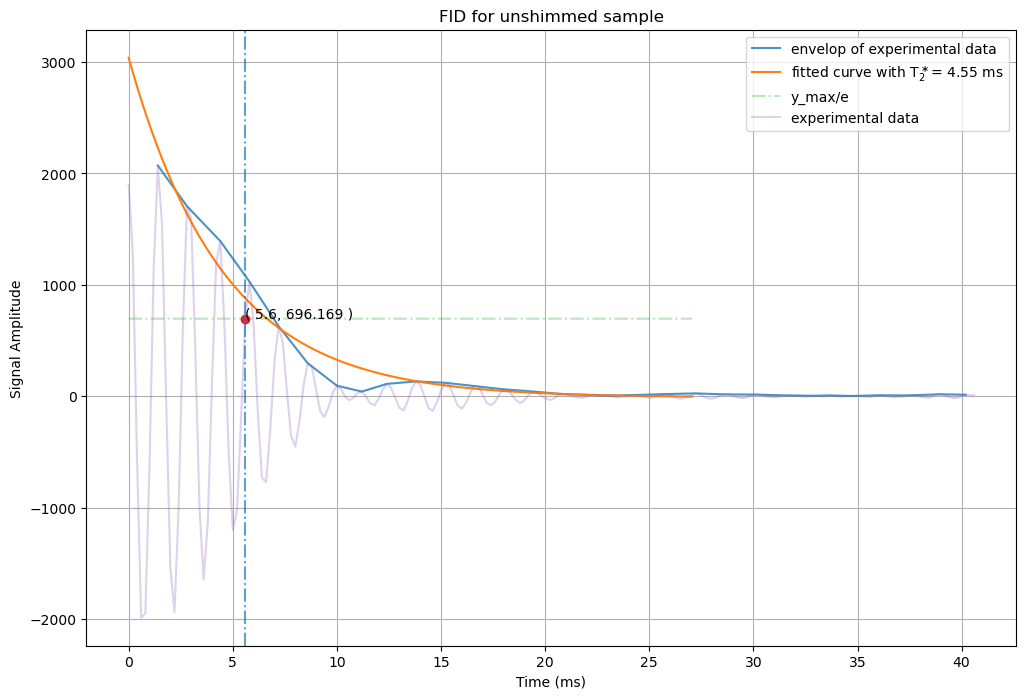

In [70]:
initial_guess = [50,2250,0,0]

popt, pcov = scipy.optimize.curve_fit(decay_exp, xs[lmax], ys[lmax], initial_guess)
print(popt)
print(pcov)

x_val = np.arange(min(xs)/1.5, max(xs)/1.5, (max(xs)- min(xs))/10000)

intersection_point = closest_value(xs, ys, ys[0]/np.e)[1]

fig,ax = plt.subplots(1, figsize=(12,8))
ax.plot(xs[lmax], ys[lmax], '-', label="envelop of experimental data", alpha=0.8)
ax.plot(x_val, decay_exp(x_val, *popt), label="fitted curve with T$_2^\\ast$= " + str(np.round(popt[0],2)) + " ms")
ax.plot(x_val, [ys[intersection_point]]*len(x_val), label="y_max/e", linestyle= '-.',  alpha=0.3)
ax.plot(xs[intersection_point], ys[intersection_point], 'o' )
ax.plot(xs, ys, '-',  alpha=0.3, label="experimental data")
ax.axvline(x = xs[intersection_point], linestyle="-.",  alpha=0.7)
ax.annotate("( "+ str(xs[intersection_point]) + ", " + str(ys[intersection_point]) + " )", (xs[intersection_point], ys[intersection_point]))

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Signal Amplitude")
ax.set_title("FID for unshimmed sample")
ax.grid()
print(2/popt[1])
ax.legend()

print("intersection value: " +str(closest_value(xs, ys, ys[0]/np.e)))